<a href="https://colab.research.google.com/github/weymouth/MarineHydro/blob/master/notebooks/wave_greens_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free surface potential flows 🌊

The goal of this notebook is to compute the potential flow and forces on a body in waves, but let's start with a recap. In the first notebook we developed a numerical method to compute the potential flow around any submerged 2D geometry using source panels. This also lets us comptue the added mass forces. Here's the code from that notebook:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def source(x,y,xs,ys): return 0.5*np.log((x-xs)**2+(y-ys)**2)

GAUSS2 = 0.5*(1+np.sqrt(1/3)) # gaussian-quadrature sample point
def potential(x,y,x0,y0,x1,y1,G=source,args=()):
  "Gaussian quadrature estimate of the potential influence function"
  def dG(s): return G(x,y,x0*(1-s)+x1*s,y0*(1-s)+y1*s,*args)
  h = np.sqrt((x1-x0)**2+(y1-y0)**2)
  return 0.5*h*sum(dG(s) for s in [GAUSS2,1-GAUSS2])

def velocity(x,y,x0,y0,x1,y1,G=source,args=(),eps=1e-6):
  "Finite difference estimate of the velocity influence function"
  def phi(x,y): return potential(x,y,x0,y0,x1,y1,G,args)
  return np.array(((phi(x+eps,y)-phi(x-eps,y))/(2*eps),  # dphi/dx
                   (phi(x,y+eps)-phi(x,y-eps))/(2*eps))) # dphi/dy

In [2]:
def plot_flow(x,y,q,XY,G=source,args=(),size=(7,7),ymax=None):
  # Loop through segments, superimposing the velocity
  def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
  UV = sum(uv(i) for i in range(len(x)-1))

  # Create plot
  plt.figure(figsize=size)
  ax=plt.axes(); ax.set_aspect('equal', adjustable='box')

  # Plot vectors and segments
  Q = plt.quiver(*XY, *np.real(UV))
  if np.iscomplexobj(UV):
    Q._init() 
    plt.quiver(*XY, *np.imag(UV), scale=Q.scale, color='g')
  plt.plot(x,y,c='b')
  plt.ylim(None,ymax)

In [3]:
def ellipse(N,a=1,b=1,theta1=np.pi):
  "x,y arrays around an elliptical arc"
  theta = np.linspace(-np.pi,theta1,N+1) # N+1 points for N panels
  return a*np.cos(theta),b*np.sin(theta)

def mask_grid(x,y,mask):
  "delete mesh points where mask is true"
  def delete(a): return np.ma.masked_array(a,mask(x,y)).compressed()
  return np.array((delete(x),delete(y)))

In [4]:
def properties(x0, y0, x1, y1):
  "properties of a line segment"
  sx, sy = x1-x0, y1-y0         # segment vector
  xc, yc = x0+0.5*sx, y0+0.5*sy # segment center 
  h = np.sqrt(sx**2+sy**2)      # segment length
  nx, ny = sy/h, -sx/h          # segment unit normal
  return xc, yc, nx, ny, h

def construct_A(x,y,G=source,args=(),aii=np.pi):
  "construct the velocity influence matrix"
  # influence of panel i on the normal velocity at each panel center
  xc, yc, nx, ny, _ = properties(x[:-1], y[:-1], x[1:], y[1:])
  def u_n(i):
    u,v = velocity(xc,yc,x[i],y[i],x[i+1],y[i+1],G,args)
    return u*nx+v*ny

  # construct matrix
  A = np.array([u_n(i) for i in range(len(yc))]).T
  A += aii*np.eye(len(yc)) # add panel self-influence
  return A,nx,ny

In [5]:
def added_mass(x,y,G=source,args=(),rho=1):
  "Compute the added mass matrix"
  # strength due to x,y motion
  A,n1,n2 = construct_A(x,y,G,args)
  q1 = np.linalg.solve(A,n1)
  q2 = np.linalg.solve(A,n2)

  # potential due to y,z motion (times panel width)
  xc,yc,_,_,h = properties(x[:-1], y[:-1], x[1:], y[1:])
  hF = [h*potential(xc,yc,x[i],y[i],x[i+1],y[i+1],G,args) for i in range(len(yc))]
  phi1,phi2 = hF@q1,hF@q2 # potential influence matrix times strength

  # sum over panels 
  return -rho*np.matrix([[phi1@n1,phi1@n2],[phi2@n1,phi2@n2]])

## Free surface Greens Function 🌊

The method above can predict the potential flow and added mass around any 2D shape (or shapes...) completely immersed in air or water. However, when an object moves near the free surface it generates waves, and this changes the flow and forces significantly. 

**We need to modify the oscillating source potential used above and add the potential flow waves which it generates.**  Here is the potential, taken from [this modern paper](https://www.researchgate.net/profile/Ed-Mackay/publication/344610701_Calculation_of_the_two-dimensional_free_surface_Green_function/links/5f84519f299bf1b53e20e1f2/Calculation-of-the-two-dimensional-free-surface-Green-function.pdf):

$$ G(x,y,x_s,y_s) = \log(r_s)-2\pi \imath e^Z-2f(Z) $$

There are three terms:

1. The first term is the **oscillating source** defined as before.

2. The second term is the **propagating wave** written using complex variables. The standard wave potential is 
$$ \phi = \frac{|\eta|g}{\omega} e^{Ky}\cos(Kx-\omega t+\Phi) $$
where $\omega$ is the oscillation frequency, $|\eta|,\Phi$ are the wave amplitude and phase and $K=\omega^2/g$ is the deep water wave number. In complex variables we have $e^{\imath\theta} = \cos\theta+\imath\sin\theta$, where $\imath=\sqrt{-1}$. Therefore we can write
$$ \phi = \text{Re}\left[|\zeta| e^{K(y+\imath x)}e^{-\imath\omega t}\right] $$
where $|\zeta|$ is a complex amplitude that includes the phase relative to the motion. The wave term in the equation above is a modification of this basic idea defining $Z=K(y+y_s+\imath(x-x_s))$ and scaling the amplitude relative to the oscillating source. 

3. Finally, the last term is a **standing wave** potential that ensures the oscillating souce satisfies the free surface boundary condition
$$ K\phi-\frac{\partial\phi}{\partial y} = 0 \quad\text{on}\quad y=0$$

Let's look at the velocity field induced by a single source panel near the free surface.

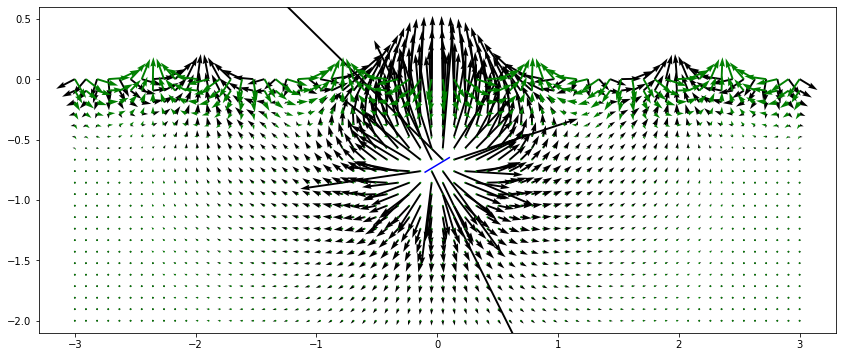

In [6]:
from scipy.special import exp1

def wave_source(x,y,xs,ys,K):
  "Source plus generated free surface waves"
  r2 = (x-xs)**2+(y-ys)**2   # source square-distance
  Z = K*(y+ys+1j*abs(x-xs))  # wave number scaled complex vector
  eZ = np.exp(Z)             # propagating wave potential
  # standing wave potential
  fZ = 2*np.real(eZ*exp1(Z))+np.log(np.abs(Z)/K)
  return 0.5*np.log(r2)-2j*np.pi*eZ-fZ

XY = np.meshgrid(np.linspace(-3,3,66),np.linspace(-2,0,22))
K = 4

plot_flow([-.1,.1],[-.77,-0.65],[1],XY,wave_source,(K,),size=(16,6),ymax=0.6)

The black arrows show the flow velocity in phase with the body velocity (the part with $\sin\omega t$ like before). Now that we have free surface waves, we also have velocity out of phase with the body ($\cos\omega t$), shown in the green arrows. 

This is easier to understand using a movie!

> **Note:** It takes a while for Python to generate the videos, so I've commented those lines out. Uncomment and play around with the flows in the following cells as much as you like.

In [7]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def wave_video(x,y,q,XY,G=wave_source,args=(4,),size=(16,6)):
  # Get complex velocity
  def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
  UV = sum(uv(i) for i in range(len(x)-1))

  # Plot flow and segments
  fig, ax = plt.subplots(1,1,figsize=size)
  Q = ax.quiver(*XY, *UV)#, pivot='mid')
  ax.plot(x,y,c='b')
  ax.set_ylim(None,0.5)
  ax.set_aspect('equal', adjustable='box')
  plt.close()

  # run through a wave period
  def update_quiver(num, Q):
      Q.set_UVC(*np.real(UV*np.exp(-2j*np.pi*num/101)))
      return Q,

  # create the animation
  return FuncAnimation(fig, update_quiver, fargs=(Q,), interval=50)

# anim = wave_video([-.1,.1],[-.77,-0.65],[1],XY)
# HTML(anim.to_html5_video())

[![Link to video](http://i3.ytimg.com/vi/3DSdek0stHM/hqdefault.jpg)](https://youtu.be/3DSdek0stHM)

Looks good. The source, standing wave above it, and the radiating waves on either side are all visible. 

> **Note:** Now that you've seen the video, go back and look at the plot above. The black and green arrows are like snapshots of the video at the start and quarter of the way through a cycle. While the movie is certainly easier to digest, it's important to realize the complex amplitude $|\phi_k|$ has all the information needed to make the movie.

---

## Solving for free surface potential flows and forces 🛥

> **Note:** The plots above use the original `velocity` function, they just apply the new `wave_source` singularity instead of the `source` singularity. Similarly, the `potential` `construct_A` and `added_mass` functions can all by applied to free surface flows without modification!

This is why writing re-usable functions is so powerful. Let's use our new Green's function to produce the flow around a semi-circular ship section in sway.

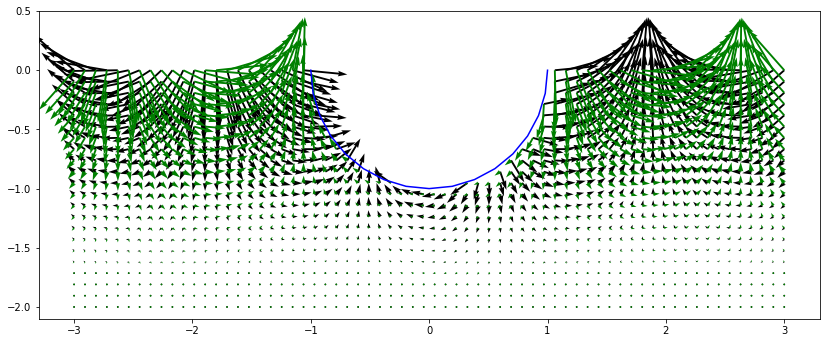

In [8]:
x,y = ellipse(16,theta1=0)
circleXY = mask_grid(*XY,mask=lambda x,y: x**2+y**2<1)
K=2
A,nx,ny = construct_A(x,y,wave_source,(K,))
plot_flow(x,y,np.linalg.solve(A,nx),circleXY,wave_source,(K,),size=(14,6),ymax=0.5)
# anim = wave_video(x,y,q,circleXY,wave_source,(K,))
# HTML(anim.to_html5_video())

That's amazing! You can clearly see the waves radiating away from the ship hull in either direction. When the ship moves to port, it forms a new crest on the port side, and vis versa!

Finally let's get the added mass:

In [9]:
ma = added_mass(x,y,wave_source,(K,))
print(np.array_str(ma, precision=3, suppress_small=True))

[[ 0.289+0.626j -0.   -0.j   ]
 [-0.   -0.j     1.109+0.232j]]


Look carefully at this result because two important things have changed since we moved into free surface flows
1. **The "added mass" has a real and complex part!** This is because some of the force is in-phase with acceleration (like before) and some is in-phase with velocity. The first part is the sectional added mass $A_{kl}$ and the second part is the wave damping $B_{kl}$. The damping is due to the energy leaving the system in the radiating waves, which is why the damping is zero when there is no free surface. 
1. **The added mass and damping depend on the motion direction and wave number!** A fully submerged circle of radius $R$ has $m_{kk}=\rho \pi R^2$ independant of the oscillation frequency or direction. But the standing and radiating waves must satisfy the free surface boundary condition, which depends on $K$, and their amplitude and phase depends on the direction of motion $k$. Therefore the added mass and damping matrices are functions of $K$ and $k$ as well.

Let's plot these coefficients for a range of dimensionless frequencies $\omega \sqrt{R/g}$

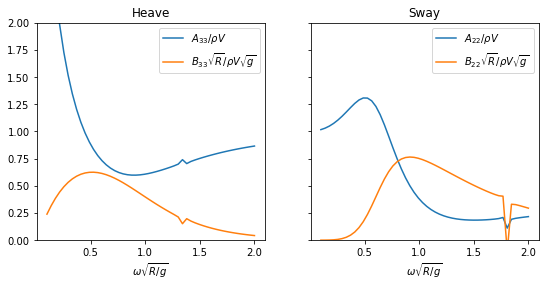

In [10]:
def force_plots(y,z,omega,rhoV=0.5*np.pi):
  @np.vectorize
  def force_coeffs(omega):
    ma = added_mass(y,z,wave_source,(omega**2,))
    return (np.real(ma[0,0])/rhoV,omega*np.imag(ma[0,0])/rhoV, #22
            np.real(ma[1,1])/rhoV,omega*np.imag(ma[1,1])/rhoV) #33

  A22,B22,A33,B33 = force_coeffs(omega)

  f, (hplt,splt) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))
  plt.ylim(0,2)
  hplt.set_title('Heave')
  hplt.plot(omega,A33,'C0',label=r'$A_{33}/\rho V$')
  hplt.plot(omega,B33,'C1',label=r'$B_{33}\sqrt{R}/\rho V\sqrt{g}$')
  splt.set_title('Sway')
  splt.plot(omega,A22,'C0',label=r'$A_{22}/\rho V$')
  splt.plot(omega,B22,'C1',label=r'$B_{22}\sqrt{R}/\rho V\sqrt{g}$')
  for ax in (hplt,splt):
    ax.set_xlabel(r'$\omega\sqrt{R/g}$');ax.legend()

omega = np.linspace(0.1,2)
y,z = ellipse(64,theta1=0)
force_plots(y,z,omega)

> **Note:** We've switched to a section in the $y,z$ plane, since this is standard for strip theory. This doesn't change *anything* in the `added_mass` or `wave_source` functions - we simply pass $y,z$ coordinates in and get sway and heave forces out.

Here are some experimental and analytic results for the added mass and damping on a semi-circle from [Vugts 1968](https://content.iospress.com/download/international-shipbuilding-progress/isp15-167-02?id=international-shipbuilding-progress%2Fisp15-167-02). 

| Heave| Sway|
|-|-|
|![heave](https://drive.google.com/uc?export=view&id=1JYMgqOeW_UEGjXzq1VrbZ5_HQXsh3ayI) | ![sway](https://drive.google.com/uc?export=view&id=19P67Q0zPyW_yquO_37lOhHZEFMJlnNiV)|


Our results match the analytic results in the paper really well (other than at two special points that we will discuss in a moment). This validates our free surface force predictions!

The potential flow methods both match the experiments nicely other than the zero frequency heave added mass. Zero frequency heave is not linear - and so linear potential flow can't predict it.

---

> **Note:** The two blips in our added mass prediction results are due to resonance *inside* the geometry! These are the frequencies we should be watch if we could potentially have sloshing cargo! 

The flow *inside* the hull is plotted below - showing an internal standing wave. This wave totally dominates the flow and causes a loss of accuracy in the added mass calculation, but we can just ignore the prediction at those points.

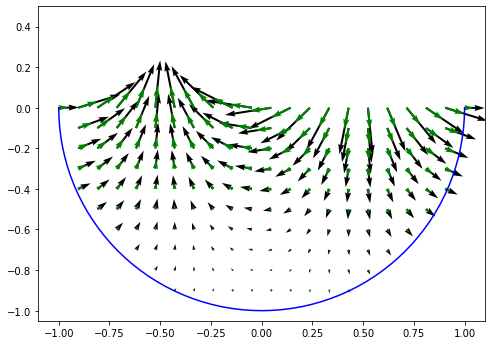

In [11]:
K = 3.25 # sway sloshing wavenumber from plot above
A,ny,nz = construct_A(y,z,wave_source,(K,))
YZ = np.meshgrid(np.linspace(-1,1,22),np.linspace(-1,0,11))
inside = mask_grid(*YZ,mask=lambda y,z: y**2+z**2>1)
plot_flow(y,z,np.linalg.solve(A,ny),inside,wave_source,(K,),size=(8,6),ymax=0.5)
# anim = wave_video(y,z,q,inside,wave_source,(K,),size=(8,6))
# HTML(anim.to_html5_video())

---

## Multiple geometries ⛵⛵

The functions above only compute the flow and forces around a single shape - they take in **one** `x,y` array pair. How can we compute the flow induced by more than one shape, like a multi-hull ship? Here are some ideas:

1. *Superposition:* Can we define the geometries, solve for each flow separately, and then add the flow and forces together? 

No. If we solve for the flows separately, we will miss the influence of the bodies on each other. When we add them up, the body BC won't be satisfied and so the flow and forces will be wrong.

2. *Concatenation:* Can we stack all the body arrays together, and then solve for the flow?

This approach includes the influence of each body on the other, but it will also create fake panels linking the bodies together. We need to zero the influence of those non-panels to use this approach - as I've done below.

3. *Images:* Can we apply the method of images to reflect the geometry across the $y$ axis?

Yes, and this is the classic approach (since it play nice with analytic models) but there are some caveats. Importantly, this only works when you have a plane of symmetry! So you can't use this to model two independent boats - even if the hulls are identical, their motions won't be. 

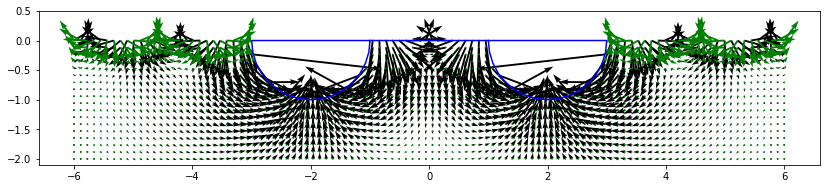

In [12]:
def circle_cat(N,g):
  ya,za = ellipse(N//2,theta1=0)
  yb,zb = ellipse(N//2,theta1=0)
  ya += 1+g
  yb -= 1+g
  return np.append(ya,yb),np.append(za,zb),[N//2]

def zero_influence(A,nx,ny,blank):
  for i in blank:
    A[i,:] = np.zeros(len(nx)); A[i,i] = 1
    nx[i] = 0; ny[i] = 0
  return A,nx,ny

N,K,gap = 32,4,1
y,z,blank = circle_cat(N,gap)
catYZ = np.meshgrid(np.linspace(-6,6,108),np.linspace(-2,0,18))
catYZ = mask_grid(*catYZ,mask=lambda y,z: (abs(y)-1-gap)**2+z**2<1)
A,ny,nz = zero_influence(*construct_A(y,z,wave_source,(K,)),blank)
q = np.linalg.solve(A,nz)
plot_flow(y,z,q,catYZ,wave_source,(K,),size=(14,6),ymax=0.5)
# anim = wave_video(y,z,q,catYZ,wave_source,(K,),size=(14,6))
# HTML(anim.to_html5_video())

Look at the wave in the center of the plot, between the two circles. Since the arrows are all black instead of green, there is no traveling wave - only a standing wave caught between the hulls. This is important for catamaran seakeeping predictions.